In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [12]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values # consists of M or B (maligant/benign)
le = LabelEncoder()
y = le.fit_transform(y) # converts M/B to 1/0

# as example, if 2 new entries are given
le.transform(['M', 'B']) # => converts to M to 1, B to 0

array([1, 0])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [15]:
# creating a pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Pipeline is initialized with an array of tuples: (var_name_to_call_obj, object)
# this pipeline does: 1. standardize data, 2. reduce comp to 2, 3. perform log reg on the 2 components
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(random_state=1))
    ])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [38]:
# K-fold cross validation method (manual)
from sklearn.cross_validation import StratifiedKFold

kfold = StratifiedKFold(y=y_train,n_folds=10,random_state=1)
scores = []

# each elem of kfold consiss of [idx of training samples, idx of testing samples],
# each elem consists of the same proportion of positive:negative samples
# note: it may be better to name 'test' to 'validation' here because that's what it is; the X_test data is not used here
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


In [36]:
# Note: np.bicount count freq of i(0,1,2 etc.) in the array, 
# and return the count in the ith position
np.bincount([1,1,1,2,2,2,2,3,3])

array([0, 3, 4, 2])

In [39]:
# k-fold validation using sklearn            
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
CV accuracy: 0.950 +/- 0.029


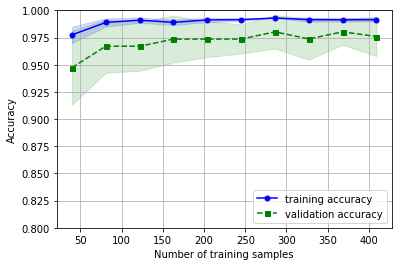

In [116]:
# plotting learning curves
# to check if biased or overfitting
from sklearn.model_selection import learning_curve
pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(random_state=0, penalty='l2'))
    ])

# using 10%, 20%...90%, 100% of the data to see the learning rate
# since this uses kfold validation, each elem of train_scores/test_scores is an array of 10 scores
train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=10,
    n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
# Alt
# train_stats = pd.DataFrame(train_scores.T).describe()
# train_mean, train_std = train_stats.loc['mean'], train_stats.loc['std']

plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

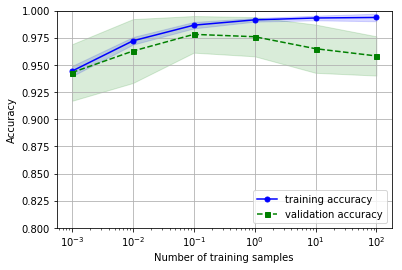

In [123]:
# Validation curves are related to learning curves, 
# but instead of plotting the training and test accuracies as functions of the sample size 
# we vary the values of the model parameters

from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

# Note: this uses kfold validation
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C', # access the param by calling 'var_name of object__param name'
    param_range=param_range,
    cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# note: same as above, but the bins are now param range
plt.plot(param_range, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(param_range, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xscale('log') # necessary since the params are of multiples
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

# best C val at 0.1

In [129]:
# tuning via grid search
# similar to validation curve, but checking combinations of hyperparameters

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([
        ('scl', StandardScaler()),
        ('clf', SVC(random_state=1))
    ])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# note: in the options hash, every element is an array
param_grid = [
    {
        'clf__C': param_range,
        'clf__kernel': ['linear'] 
    },
    {
        'clf__C': param_range,
        'clf__gamma': param_range,
        'clf__kernel': ['rbf']
    }
]

# note: this uses k-fold validation for testing each model
gs = GridSearchCV(estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [133]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


In [134]:
# nested cross validation, i.e cross validation WITH Grid search, i.e. an outer loop & inner loop
# see reasoning for use: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
# mainly for tuning model parameters without overfitting it to the data by checking its accuracy on different datasets
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.972 +/- 0.012


In [136]:
# Example: Using nested cross validation on GridSearch fitting a DecisionTree model
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[
        {'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}
    ],
    scoring='accuracy',
    cv=5)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5) # Not sure why the suthor uses training data here instead of the whole data
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.908 +/- 0.045


## Evaluating a model performance with precision/recall

In [141]:
# Confusion matrix -- just for demonstration purposes (can skip)

from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


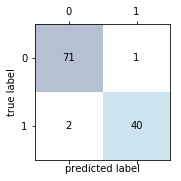

In [144]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

In [147]:
# if it ever happens that you need to know the precision/recall/F1 values directly
# precision, recall and F1
from sklearn.metrics import precision_score
from sklearn.metrics  import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [148]:
# using score other than 'accuracy', e.g. F1, on grid search (demonstration)
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0) # can change pos label, default: pos_label=1; now set to positively evaluate benign
gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring=scorer,
    cv=10)

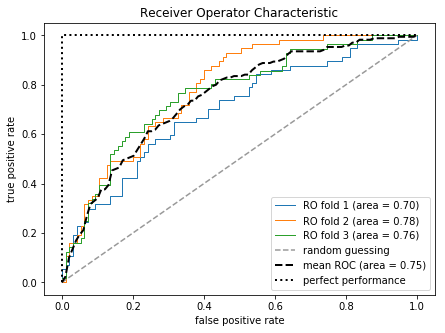

In [209]:
# Receiver operator characteristic (ROC) graphs: - false positive against true positive
from sklearn.metrics import roc_curve, auc
from scipy import interp

# for demo, using just 2 components & 3 folds
X_train2 = X_train[:, [4, 14]] 
cv = StratifiedKFold(y_train,
    n_folds=3,
    random_state=1)
fig = plt.figure(figsize=(7, 5))
mean_tpr = 0.0 # tpr = true positive rate
mean_fpr = np.linspace(0, 1, 100) # fpr = false positive rate;   linspace creates array of 100 elem of equidistant between 0 to 1
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test]) # return 2 elem array [prob of 0, prob of 1]
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:, 1], pos_label=1) # usage: roc_curve(actual_binary_labels, prob_of_pos_class, pos_label)
    # see doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    # returns the fpr and tpr respective to different thresholds of predicting the positive class
    
    # create interpolation points at the defined linear space points, because the thresholds will be different for each fold, so the x-axis needs to be standardized to use the same points to sum
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0

    # plot line for current fold
    roc_auc = auc(fpr,tpr) # area under curve. usage: auc(x_arr, y_arr)
    plt.plot(fpr, tpr, lw=1, label='RO fold %d (area = %0.2f)' % (i+1, roc_auc))
    
# plot diagonal line in graph to show prob of random guessing 
plt.plot([0, 1],[0,1], linestyle='--', color=(0.6,0.6,0.6),label='random guessing')
# averaging the tpr across folds
mean_tpr /= len(cv) # len(cv) = 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
# plot straight lines in graph to show perfect perf
plt.plot([0, 0, 1], [0, 1, 1],lw=2,linestyle=':',color='black',label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [211]:
# just calculating the AUC score
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[:, [4, 14]])

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

ROC AUC: 0.671
Accuracy: 0.728
